# How to load PDFs

[Portable Document Format (PDF)](https://en.wikipedia.org/wiki/PDF), standardized as ISO 32000, is a file format developed by Adobe in 1992 to present documents, including text formatting and images, in a manner independent of application software, hardware, and operating systems.

This guide covers how to [load](/docs/concepts/document_loaders/) `PDF` documents into the LangChain [Document](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html) format that we use downstream.

Text in PDFs is typically represented via text boxes. They may also contain images. A PDF parser might do some combination of the following:

- Agglomerate text boxes into lines, paragraphs, and other structures via heuristics or ML inference;
- Run [OCR](https://en.wikipedia.org/wiki/Optical_character_recognition) on images to detect text therein;
- Classify text as belonging to paragraphs, lists, tables, or other structures;
- Structure text into table rows and columns, or key-value pairs.

LangChain integrates with a host of PDF parsers. Some are simple and relatively low-level; others will support OCR and image-processing, or perform advanced document layout analysis. The right choice will depend on your needs. Below we enumerate the possibilities.

We will demonstrate these approaches on a [sample file](https://github.com/langchain-ai/langchain/blob/master/libs/community/tests/integration_tests/examples/layout-parser-paper.pdf):

In [13]:
%pip install -qU pypdf

Note: you may need to restart the kernel to use updated packages.


In [15]:
%pip install langchain_community

  Using cached langchain_community-0.3.18-py3-none-any.whl.metadata (2.4 kB)
  Using cached langchain-0.3.19-py3-none-any.whl.metadata (7.9 kB)
  Using cached pydantic_settings-2.8.0-py3-none-any.whl.metadata (3.5 kB)
  Using cached httpx_sse-0.4.0-py3-none-any.whl.metadata (9.0 kB)
  Using cached langchain_text_splitters-0.3.6-py3-none-any.whl.metadata (1.9 kB)
Using cached langchain_community-0.3.18-py3-none-any.whl (2.5 MB)
Using cached httpx_sse-0.4.0-py3-none-any.whl (7.8 kB)
Using cached langchain-0.3.19-py3-none-any.whl (1.0 MB)
Using cached pydantic_settings-2.8.0-py3-none-any.whl (30 kB)
Using cached langchain_text_splitters-0.3.6-py3-none-any.whl (31 kB)
  Attempting uninstall: langchain
    Found existing installation: langchain 0.0.284
    Uninstalling langchain-0.0.284:
      Successfully uninstalled langchain-0.0.284
Note: you may need to restart the kernel to use updated packages.


In [7]:
file_path = (
    "F:\\learning\\HDFC_Base_chatbot\\notebooks\\HDFC Bank Fixed Deposit article_v1.0.pdf"
)

In [8]:
pwd

'f:\\learning\\HDFC_Base_chatbot\\notebooks'

:::info A note on multimodal models

Many modern LLMs support inference over multimodal inputs (e.g., images). In some applications -- such as question-answering over PDFs with complex layouts, diagrams, or scans -- it may be advantageous to skip the PDF parsing, instead casting a PDF page to an image and passing it to a model directly. We demonstrate an example of this in the [Use of multimodal models](/docs/how_to/document_loader_pdf/#use-of-multimodal-models) section below.

:::

## Simple and fast text extraction

If you are looking for a simple string representation of text that is embedded in a PDF, the method below is appropriate. It will return a list of [Document](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html) objects-- one per page-- containing a single string of the page's text in the Document's `page_content` attribute. It will not parse text in images or scanned PDF pages. Under the hood it uses the [pypdf](https://pypdf.readthedocs.io/en/stable/) Python library.

LangChain [document loaders](/docs/concepts/document_loaders) implement `lazy_load` and its async variant, `alazy_load`, which return iterators of `Document` objects. We will use these below.

In [9]:
%pip install -qU pypdf

Note: you may need to restart the kernel to use updated packages.


In [64]:
import os
# import streamlit as st
import pickle
import time
import langchain
from langchain import OpenAI
from langchain.chains import RetrievalQAWithSourcesChain
from langchain.chains.qa_with_sources.loading import load_qa_with_sources_chain
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import UnstructuredURLLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS

In [16]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [17]:
print(f"{pages[0].metadata}\n")
print(pages[0].page_content)

{'producer': 'Microsoft® Word 2019', 'creator': 'Microsoft® Word 2019', 'creationdate': '2025-02-23T18:52:04+05:30', 'author': 'Narottam Saini', 'moddate': '2025-02-23T18:52:04+05:30', 'source': 'F:\\learning\\HDFC_Base_chatbot\\notebooks\\HDFC Bank Fixed Deposit article_v1.0.pdf', 'total_pages': 22, 'page': 0, 'page_label': '1'}

HDFC Bank Fixed Deposit article:: 
URL: FD Interest Rates (February 2025) - Check Fixed Deposit Interest Rates | HDFC Bank 
1. FD Interest Rates (February 2025) - Check Fixed Deposit Rates Online 
Fixed Deposit has been a popular investment option across generations, and for a good 
reason. If you are looking for a safe investment, a Fixed Deposit is an excellent option. At 
HDFC Bank, you can open a Fixed Deposit with amounts as low as ₹5,000. Invest a sum of 
your choice and pick from a range of tenures suitable to you. 
Fixed Deposit is widely preferred by many as it provides guaranteed returns. When you 
deposit funds in a Fixed Deposit, you can grow your

In [18]:
print(f"{pages[1].metadata}\n")
print(pages[1].page_content)

{'producer': 'Microsoft® Word 2019', 'creator': 'Microsoft® Word 2019', 'creationdate': '2025-02-23T18:52:04+05:30', 'author': 'Narottam Saini', 'moddate': '2025-02-23T18:52:04+05:30', 'source': 'F:\\learning\\HDFC_Base_chatbot\\notebooks\\HDFC Bank Fixed Deposit article_v1.0.pdf', 'total_pages': 22, 'page': 1, 'page_label': '2'}

(Senior Citizen Rates do not apply to NRIs | Minimum tenor for NRE Deposit is 1 Year.) 
Tenor Bucket < 3 Crore 
 Interest Rate (per 
annum) 
**Senior Citizen Rates (per 
annum) 
7 - 14 days 3.00% 3.50% 
15 - 29 days 3.00% 3.50% 
30 - 45 days 3.50% 4.00% 
46 - 60 days 4.50% 5.00% 
61 - 89 days 4.50% 5.00% 
90 days < = 6 months 4.50% 5.00% 
6 months 1 days < = 9 months 5.75% 6.25% 
9 months 1 day to < 1 year 6.00% 6.50% 
1 year to < 15 months 6.60% 7.10% 
15 months to < 18 months 7.10% 7.60% 
18 months to < 21 months 7.25% 7.75% 
21 months - 2 years 7.00% 7.50% 
2 Years 1 day to < 2 Year 11 
Months 7.00% 7.50% 
2 Years 11 Months - 35 
Months 7.35% 7.85%


Note that the metadata of each document stores the corresponding page number.

### Vector search over PDFs

Once we have loaded PDFs into LangChain `Document` objects, we can index them (e.g., a RAG application) in the usual way. Below we use OpenAI embeddings, although any LangChain [embeddings](https://python.langchain.com/docs/concepts/embedding_models) model will suffice.

In [19]:
%pip install -qU langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [20]:
from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env (especially openai api key)

True

In [ ]:
import getpass
import os
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY') #getpass.getpass("OpenAI API Key:")

In [54]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

vector_store = InMemoryVectorStore.from_documents(pages, OpenAIEmbeddings())
docs = vector_store.similarity_search("What is benefits of the fixed deposit", k=3)

docs


INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


[Document(id='65daf3c4-a813-4cbe-b843-1363dbb37d7e', metadata={'producer': 'Microsoft® Word 2019', 'creator': 'Microsoft® Word 2019', 'creationdate': '2025-02-23T18:52:04+05:30', 'author': 'Narottam Saini', 'moddate': '2025-02-23T18:52:04+05:30', 'source': 'F:\\learning\\HDFC_Base_chatbot\\notebooks\\HDFC Bank Fixed Deposit article_v1.0.pdf', 'total_pages': 22, 'page': 17, 'page_label': '18'}, page_content='4. Consider splitting your investments between FDs and other investment instruments \nto balance risk and returns. \n5. Be mindful of premature withdrawals, as they can attract penalties. \n \nWhat are Fixed Deposit Interest Rates? \n \nFixed Deposits, also known as FDs, are a popular investment option in India, known for their \nstability. With FDs, you can deposit a certain specific amount for a predetermined period at \nan agreed-upon interest rate. \n \nThe FD interest rate signifies the percentage of interest you will earn on the principal \namount over your FD tenure. You will

In [55]:
for doc in docs:
    print(f'Page {doc.metadata["page"]}: {doc.page_content[:300]}\n')

Page 17: 4. Consider splitting your investments between FDs and other investment instruments 
to balance risk and returns. 
5. Be mindful of premature withdrawals, as they can attract penalties. 
 
What are Fixed Deposit Interest Rates? 
 
Fixed Deposits, also known as FDs, are a popular investment option in

Page 16: • Premature Withdrawal Available: You can close your FD before its maturity date. 
Note that doing so will attract premature withdrawal penalties. 
• Autorenewal Facility: The bank will automatically renew your FD per the previous 
arrangement, at prevailing interest rates. You may provide renewal i

Page 15: The FD interest rate signifies the percentage of interest you will earn on the principal 
amount over your FD tenure. You will earn different rates for different tenures. The FD 
interest rates are influenced by factors like the Reserve Bank of India’s (RBI) monetary policy, 
inflation rates, and th



In [60]:
docs = vector_store.similarity_search("What is interest rate in fixed deposit for 1 year duration", k=2)

docs

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


[Document(id='978f618f-fc80-45f3-9435-26a237494242', metadata={'producer': 'Microsoft® Word 2019', 'creator': 'Microsoft® Word 2019', 'creationdate': '2025-02-23T18:52:04+05:30', 'author': 'Narottam Saini', 'moddate': '2025-02-23T18:52:04+05:30', 'source': 'F:\\learning\\HDFC_Base_chatbot\\notebooks\\HDFC Bank Fixed Deposit article_v1.0.pdf', 'total_pages': 22, 'page': 2, 'page_label': '3'}, page_content='2 Years 11 Months 1 day < = 3 \nYear 7.00% 7.50% \n3 Years 1 day to < 4 Years 7 \nMonths 7.00% 7.50% \n4 Year 7 Months - 55 months 7.40% 7.90% \n4 Year 7 Months 1 day < = 5 \nYears 7.00% 7.50% \n5 Years 1 day - 10 Years 7.00% 7.50% \n \nRESIDENT CUSTOMERS: \nClick here to book a deposit new way, using your mobile no.  \n \nClick here to book a deposit via NetBanking > Accounts > Transact \n \n \nNRI CUSTOMERS: \n \nNEW Customers: Click here to talk to our Executive!!  \nEXISTING Customers: Click here to book a deposit online through NetBanking!! \n1.2 Fixed Deposit Interest Rate Great

In [61]:
for doc in docs:
    print(f'Page {doc.metadata["page"]}: {doc.page_content[:300]}\n')

Page 2: 2 Years 11 Months 1 day < = 3 
Year 7.00% 7.50% 
3 Years 1 day to < 4 Years 7 
Months 7.00% 7.50% 
4 Year 7 Months - 55 months 7.40% 7.90% 
4 Year 7 Months 1 day < = 5 
Years 7.00% 7.50% 
5 Years 1 day - 10 Years 7.00% 7.50% 
 
RESIDENT CUSTOMERS: 
Click here to book a deposit new way, using your mo

Page 13: Exemption from 
penalty on 
premature 
withdrawal  
• Central or State Government establishments such as Apex Bodies, Union 
Government, State Government, Union Territories Government, 
Legislature, Judiciary, Embassies, Missions, Panchayat, District, Local 
Body and certain other entities which are



### (2) Split data to create chunks

In [65]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

# As data is of type documents we can directly use split_documents over split_text in order to get the chunks.
docs = text_splitter.split_documents(pages)

In [67]:
len(docs), docs[0]

(47,
 Document(metadata={'producer': 'Microsoft® Word 2019', 'creator': 'Microsoft® Word 2019', 'creationdate': '2025-02-23T18:52:04+05:30', 'author': 'Narottam Saini', 'moddate': '2025-02-23T18:52:04+05:30', 'source': 'F:\\learning\\HDFC_Base_chatbot\\notebooks\\HDFC Bank Fixed Deposit article_v1.0.pdf', 'total_pages': 22, 'page': 0, 'page_label': '1'}, page_content='HDFC Bank Fixed Deposit article:: \nURL: FD Interest Rates (February 2025) - Check Fixed Deposit Interest Rates | HDFC Bank \n1. FD Interest Rates (February 2025) - Check Fixed Deposit Rates Online \nFixed Deposit has been a popular investment option across generations, and for a good \nreason. If you are looking for a safe investment, a Fixed Deposit is an excellent option. At \nHDFC Bank, you can open a Fixed Deposit with amounts as low as ₹5,000. Invest a sum of \nyour choice and pick from a range of tenures suitable to you. \nFixed Deposit is widely preferred by many as it provides guaranteed returns. When you \ndepos

### (3) Create embeddings for these chunks and save them to FAISS index

In [73]:
# Create the embeddings of the chunks using openAIEmbeddings
embedding= OpenAIEmbeddings(model='text-embedding-ada-002')

# Pass the documents and embeddings inorder to create FAISS vector index
vectorindex_openai_pdf = FAISS.from_documents(docs, embedding)

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [74]:
# Storing vector index create in local
file_path="pdf_vector_index.pkl"
with open(file_path, "wb") as f:
    pickle.dump(vectorindex_openai_pdf, f)

TypeError: cannot pickle '_thread.RLock' object

## Layout analysis and extraction of text from images

If you require a more granular segmentation of text (e.g., into distinct paragraphs, titles, tables, or other structures) or require extraction of text from images, the method below is appropriate. It will return a list of [Document](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html) objects, where each object represents a structure on the page. The Document's metadata stores the page number and other information related to the object (e.g., it might store table rows and columns in the case of a table object).

Under the hood it uses the `langchain-unstructured` library. See the [integration docs](/docs/integrations/document_loaders/unstructured_file/) for more information about using [Unstructured](https://docs.unstructured.io/welcome) with LangChain.

Unstructured supports multiple parameters for PDF parsing:
- `strategy` (e.g., `"fast"` or `"hi-res"`)
- API or local processing. You will need an API key to use the API.

The [hi-res](https://docs.unstructured.io/api-reference/how-to/choose-hi-res-model) strategy provides support for document layout analysis and OCR. We demonstrate it below via the API. See [local parsing](/docs/how_to/document_loader_pdf/#local-parsing) section below for considerations when running locally.

In [25]:
%pip install -qU langchain-unstructured

Note: you may need to restart the kernel to use updated packages.


In [26]:
import getpass
import os

if "UNSTRUCTURED_API_KEY" not in os.environ:
    os.environ["UNSTRUCTURED_API_KEY"] = os.getenv('UNSTRUCTURED_API_KEY')##getpass.getpass("Unstructured API Key:")

As before, we initialize a loader and load documents lazily:

In [ ]:
from langchain_unstructured import UnstructuredLoader

loader = UnstructuredLoader(
    file_path=file_path,
    strategy="hi_res",
    partition_via_api=True,
    coordinates=True,
    api_key='7LZLKQLC5ZRREbxmC55OJ9g3GGPnoD',    ##os.getenv('UNSTRUCTURED_API_KEY'),
    web_url='https://api.unstructured.io'
)
docs = []
for doc in loader.lazy_load():
    docs.append(doc)

INFO: HTTP Request: GET https://api.unstructuredapp.io/general/docs "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 401 Unauthorized"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 401 Unauthorized"
ERROR: Failed to partition set 1.


ServerError: {"detail":"API key is invalid, please provide a valid API key in the header."}

In [47]:
import os

from unstructured_ingest.v2.pipeline.pipeline import Pipeline
from unstructured_ingest.v2.interfaces import ProcessorConfig
from unstructured_ingest.v2.processes.connectors.local import (
    LocalIndexerConfig,
    LocalDownloaderConfig,
    LocalConnectionConfig,
    LocalUploaderConfig
)
from unstructured_ingest.v2.processes.partitioner import PartitionerConfig

if __name__ == "__main__":
    Pipeline.from_configs(
        context=ProcessorConfig(),
        indexer_config=LocalIndexerConfig(input_path='F:\\learning\\HDFC_Base_chatbot\\notebooks\\HDFC Bank Fixed Deposit article_v1.0.pdf'),
        downloader_config=LocalDownloaderConfig(),
        source_connection_config=LocalConnectionConfig(),
        partitioner_config=PartitionerConfig(
            partition_by_api=True,
            api_key=os.getenv("UNSTRUCTURED_API_KEY"),
            partition_endpoint=os.getenv("UNSTRUCTURED_API_URL"),
            strategy="hi_res",
            additional_partition_args={
                "split_pdf_page": True,
                "split_pdf_allow_failed": True,
                "split_pdf_concurrency_level": 15
            }
        ),
        uploader_config=LocalUploaderConfig(output_dir='F:\\learning\\HDFC_Base_chatbot\\notebooks\\HDFC Bank Fixed Deposit article_v1.0_structured.pdf')##uploader_config=LocalUploaderConfig(output_dir=os.getenv("LOCAL_FILE_OUTPUT_DIR"))
        
    ).run()

2025-02-23 19:47:35,801 MainProcess INFO     created indexer with configs: {"input_path": "F:\\learning\\HDFC_Base_chatbot\\notebooks\\HDFC Bank Fixed Deposit article_v1.0.pdf", "recursive": false}, connection configs: {"access_config": "**********"}
2025-02-23 19:47:35,804 MainProcess INFO     Created download with configs: {"download_dir": null}, connection configs: {"access_config": "**********"}
2025-02-23 19:47:35,816 MainProcess INFO     created partition with configs: {"strategy": "hi_res", "ocr_languages": null, "encoding": null, "additional_partition_args": {"split_pdf_page": true, "split_pdf_allow_failed": true, "split_pdf_concurrency_level": 15}, "skip_infer_table_types": null, "fields_include": ["element_id", "text", "type", "metadata", "embeddings"], "flatten_metadata": false, "metadata_exclude": [], "element_exclude": [], "metadata_include": [], "partition_endpoint": "https://api.unstructured.io", "partition_by_api": true, "api_key": "*******", "hi_res_model_name": null, 

PipelineError: Pipeline did not run successfully

In [45]:
x=os.getenv("LOCAL_FILE_INPUT_DIR")
x

Here we recover 171 distinct structures over the 16 page document:

In [ ]:
print(len(docs))

171


We can use the document metadata to recover content from a single page:

In [ ]:
first_page_docs = [doc for doc in docs if doc.metadata.get("page_number") == 1]

for doc in first_page_docs:
    print(doc.page_content)

LayoutParser: A Uniﬁed Toolkit for Deep Learning Based Document Image Analysis
1 2 0 2 n u J 1 2 ] V C . s c [ 2 v 8 4 3 5 1 . 3 0 1 2 : v i X r a
Zejiang Shen® (<), Ruochen Zhang?, Melissa Dell®, Benjamin Charles Germain Lee?, Jacob Carlson®, and Weining Li®
1 Allen Institute for AI shannons@allenai.org 2 Brown University ruochen zhang@brown.edu 3 Harvard University {melissadell,jacob carlson}@fas.harvard.edu 4 University of Washington bcgl@cs.washington.edu 5 University of Waterloo w422li@uwaterloo.ca
Abstract. Recent advances in document image analysis (DIA) have been primarily driven by the application of neural networks. Ideally, research outcomes could be easily deployed in production and extended for further investigation. However, various factors like loosely organized codebases and sophisticated model conﬁgurations complicate the easy reuse of im- portant innovations by a wide audience. Though there have been on-going eﬀorts to improve reusability and simplify deep learning (D

### Extracting tables and other structures

Each `Document` we load represents a structure, like a title, paragraph, or table.

Some structures may be of special interest for indexing or question-answering tasks. These structures may be:
1. Classified for easy identification;
2. Parsed into a more structured representation.

Below, we identify and extract a table:

<details>
<summary>Click to expand code for rendering pages</summary>

%pip install -qU matplotlib PyMuPDF pillow

In [ ]:
import fitz
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image


def plot_pdf_with_boxes(pdf_page, segments):
    pix = pdf_page.get_pixmap()
    pil_image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(pil_image)
    categories = set()
    category_to_color = {
        "Title": "orchid",
        "Image": "forestgreen",
        "Table": "tomato",
    }
    for segment in segments:
        points = segment["coordinates"]["points"]
        layout_width = segment["coordinates"]["layout_width"]
        layout_height = segment["coordinates"]["layout_height"]
        scaled_points = [
            (x * pix.width / layout_width, y * pix.height / layout_height)
            for x, y in points
        ]
        box_color = category_to_color.get(segment["category"], "deepskyblue")
        categories.add(segment["category"])
        rect = patches.Polygon(
            scaled_points, linewidth=1, edgecolor=box_color, facecolor="none"
        )
        ax.add_patch(rect)

    # Make legend
    legend_handles = [patches.Patch(color="deepskyblue", label="Text")]
    for category in ["Title", "Image", "Table"]:
        if category in categories:
            legend_handles.append(
                patches.Patch(color=category_to_color[category], label=category)
            )
    ax.axis("off")
    ax.legend(handles=legend_handles, loc="upper right")
    plt.tight_layout()
    plt.show()


def render_page(doc_list: list, page_number: int, print_text=True) -> None:
    pdf_page = fitz.open(file_path).load_page(page_number - 1)
    page_docs = [
        doc for doc in doc_list if doc.metadata.get("page_number") == page_number
    ]
    segments = [doc.metadata for doc in page_docs]
    plot_pdf_with_boxes(pdf_page, segments)
    if print_text:
        for doc in page_docs:
            print(f"{doc.page_content}\n")

</details>

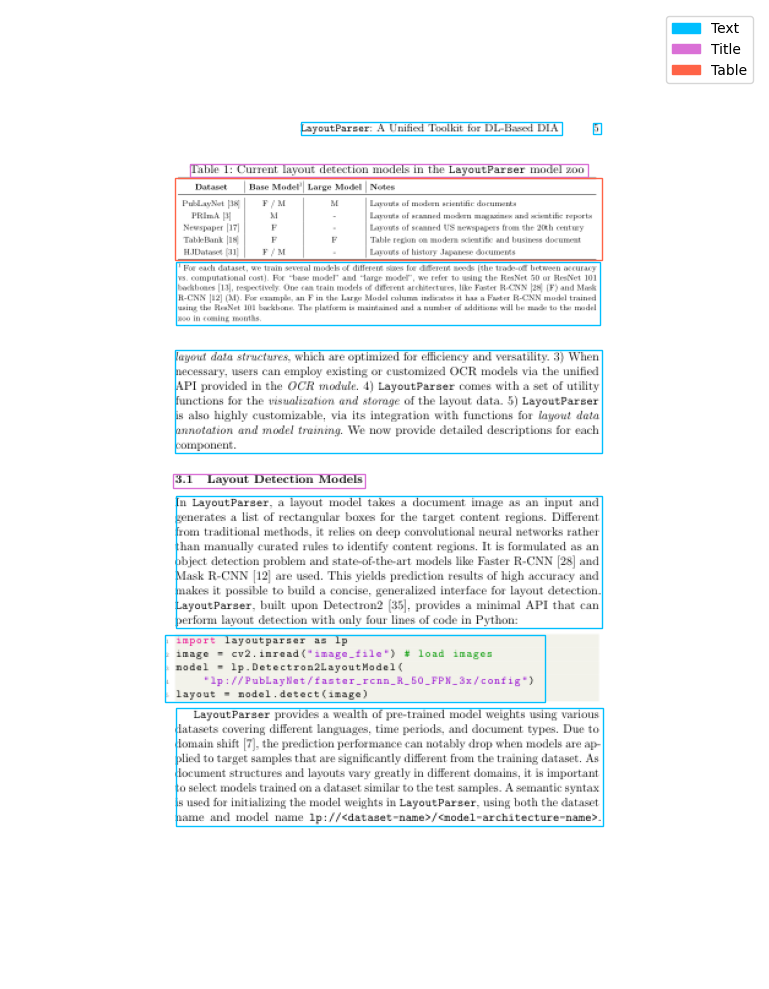

LayoutParser: A Uniﬁed Toolkit for DL-Based DIA

5

Table 1: Current layout detection models in the LayoutParser model zoo

Dataset Base Model1 Large Model Notes PubLayNet [38] PRImA [3] Newspaper [17] TableBank [18] HJDataset [31] F / M M F F F / M M - - F - Layouts of modern scientiﬁc documents Layouts of scanned modern magazines and scientiﬁc reports Layouts of scanned US newspapers from the 20th century Table region on modern scientiﬁc and business document Layouts of history Japanese documents

1 For each dataset, we train several models of diﬀerent sizes for diﬀerent needs (the trade-oﬀ between accuracy vs. computational cost). For “base model” and “large model”, we refer to using the ResNet 50 or ResNet 101 backbones [13], respectively. One can train models of diﬀerent architectures, like Faster R-CNN [28] (F) and Mask R-CNN [12] (M). For example, an F in the Large Model column indicates it has a Faster R-CNN model trained using the ResNet 101 backbone. The platform is maintaine

In [ ]:
render_page(docs, 5)

Note that although the table text is collapsed into a single string in the document's content, the metadata contains a representation of its rows and columns:

In [48]:
from IPython.display import HTML, display

segments = [
    doc.metadata
    for doc in docs
    if doc.metadata.get("page_number") == 5 and doc.metadata.get("category") == "Table"
]

display(HTML(segments[0]["text_as_html"]))

IndexError: list index out of range

<table><thead><tr><th colspan="3">able 1. LUllclll 1ayoul actCCLloll 1110AdCs 111 L1C LayoOulralsel 1110U4cl 200</th></tr><tr><th>Dataset</th><th>| Base Model\'|</th><th>Notes</th></tr></thead><tbody><tr><td>PubLayNet [38]</td><td>F/M</td><td>Layouts of modern scientific documents</td></tr><tr><td>PRImA</td><td>M</td><td>Layouts of scanned modern magazines and scientific reports</td></tr><tr><td>Newspaper</td><td>F</td><td>Layouts of scanned US newspapers from the 20th century</td></tr><tr><td>TableBank [18]</td><td>F</td><td>Table region on modern scientific and business document</td></tr><tr><td>HJDataset</td><td>F/M</td><td>Layouts of history Japanese documents</td></tr></tbody></table>

### Extracting text from specific sections

Structures may have parent-child relationships -- for example, a paragraph might belong to a section with a title. If a section is of particular interest (e.g., for indexing) we can isolate the corresponding `Document` objects.

Below, we extract all text associated with the document's "Conclusion" section:

In [49]:
render_page(docs, 14, print_text=False)

NameError: name 'render_page' is not defined

In [50]:
conclusion_docs = []
parent_id = -1
for doc in docs:
    if doc.metadata["category"] == "Title" and "Conclusion" in doc.page_content:
        parent_id = doc.metadata["element_id"]
    if doc.metadata.get("parent_id") == parent_id:
        conclusion_docs.append(doc)

for doc in conclusion_docs:
    print(doc.page_content)

### Extracting text from images

OCR is run on images, enabling the extraction of text therein:

In [51]:
render_page(docs, 11)

NameError: name 'render_page' is not defined

Note that the text from the figure on the right is extracted and incorporated into the content of the `Document`.

### Local parsing

Parsing locally requires the installation of additional dependencies.

**Poppler** (PDF analysis)
- Linux: `apt-get install poppler-utils`
- Mac: `brew install poppler`
- Windows: https://github.com/oschwartz10612/poppler-windows

**Tesseract** (OCR)
- Linux: `apt-get install tesseract-ocr`
- Mac: `brew install tesseract`
- Windows: https://github.com/UB-Mannheim/tesseract/wiki#tesseract-installer-for-windows

We will also need to install the `unstructured` PDF extras:

In [52]:
%pip install -qU "unstructured[pdf]"

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.22.0 requires protobuf<4,>=3.12, but you have protobuf 5.29.3 which is incompatible.


We can then use the [UnstructuredLoader](https://python.langchain.com/api_reference/unstructured/document_loaders/langchain_unstructured.document_loaders.UnstructuredLoader.html) much the same way, forgoing the API key and `partition_via_api` setting:

In [53]:
loader_local = UnstructuredLoader(
    file_path=file_path,
    strategy="hi_res",
)
docs_local = []
for doc in loader_local.lazy_load():
    docs_local.append(doc)

f:\learning\HDFC_Base_chatbot\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: generated new fontManager
INFO: pikepdf C++ to Python logger bridge initialized
INFO: Reading PDF for file: F:\learning\HDFC_Base_chatbot\notebooks\HDFC Bank Fixed Deposit article_v1.0.pdf ...


PDFInfoNotInstalledError: Unable to get page count. Is poppler installed and in PATH?

The list of documents can then be processed similarly to those obtained from the API.

## Use of multimodal models

Many modern LLMs support inference over multimodal inputs (e.g., images). In some applications-- such as question-answering over PDFs with complex layouts, diagrams, or scans-- it may be advantageous to skip the PDF parsing, instead casting a PDF page to an image and passing it to a model directly. This allows a model to reason over the two dimensional content on the page, instead of a "one-dimensional" string representation.

In principle we can use any LangChain [chat model](/docs/concepts/chat_models) that supports multimodal inputs. A list of these models is documented [here](/docs/integrations/chat/). Below we use OpenAI's `gpt-4o-mini`.

First we define a short utility function to convert a PDF page to a base64-encoded image:

In [ ]:
%pip install -qU PyMuPDF pillow langchain-openai

In [ ]:
import base64
import io

import fitz
from PIL import Image


def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

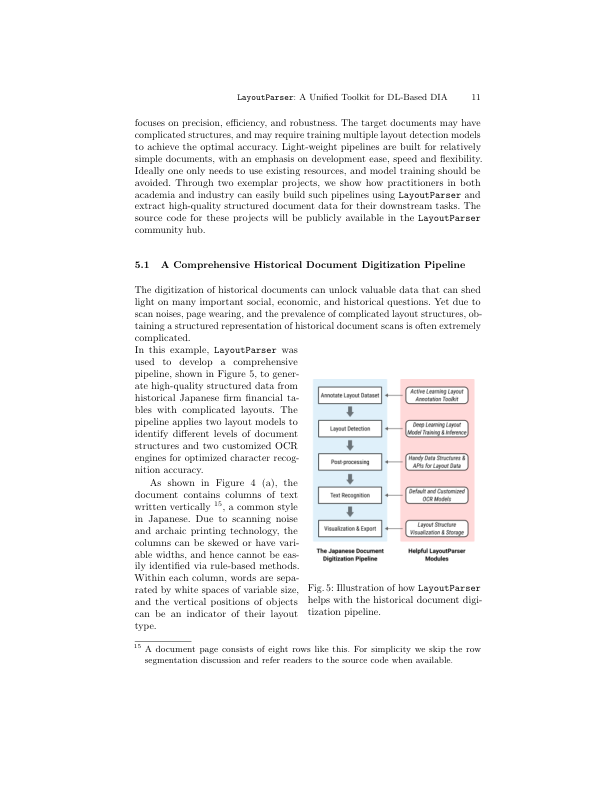

In [ ]:
from IPython.display import Image as IPImage
from IPython.display import display

base64_image = pdf_page_to_base64(file_path, 11)
display(IPImage(data=base64.b64decode(base64_image)))

We can then query the model in the [usual way](/docs/how_to/multimodal_inputs/). Below we ask it a question on related to the diagram on the page.

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [ ]:
from langchain_core.messages import HumanMessage

query = "What is the name of the first step in the pipeline?"

message = HumanMessage(
    content=[
        {"type": "text", "text": query},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
        },
    ],
)
response = llm.invoke([message])
print(response.content)

INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The first step in the pipeline is "Annotate Layout Dataset."


## Other PDF loaders

For a list of available LangChain PDF loaders, please see [this table](/docs/integrations/document_loaders/#pdfs).